# Samplers, samplers, everywhere...

This notebook aims to provide a basic example of how to run a variety of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) and [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) codes in [Python](https://www.python.org/). It won't go into detail about MCMC methods in general, and assumes a bit of knowledge about them, nor will it discuss all the various bells-and-whistles that each sampler can use, but it will hopefully help people get started with writing code to use a sampler using an understandable (albeit "toy") example. A very nice, quite similar, article on this topic by [Jake VanderPlas](http://vanderplas.com/) can be found [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). There are also very good [online notes](http://people.duke.edu/~ccc14/sta-663-2017/20A_MCMC.html) from the _Computational Statistics and Statistical Computing_ course at [Duke University](https://www.duke.edu/) by [Cliburn Chan](https://genome.duke.edu/directory/cbb-faculty/cliburn-chan-phd) & [Janice McCarthy](https://scholars.duke.edu/person/janice.mccarthy), covering some of this material (including [PyMC3](http://people.duke.edu/~ccc14/sta-663-2017/19A_PyMC3.html) and [PyStan](http://people.duke.edu/~ccc14/sta-663-2017/19B_Pystan.html#estimating-parameters-of-a-linear-regression-model) examples that are very similar to what is covered here). 

## Background

MCMC methods are often used in the context of Bayesian parameter estimation, e.g., you have a model, $y$, defined by a set of unknown parameters, ${\vec{\theta}}$, with certain prior probability distributions $p(\vec{\theta}|I)$, and you want to sample from the marginalised posterior probability distributions on those parameters given some data, $\mathbf{d}$, and a particular likelihood function, $p(\mathbf{d}|\vec{\theta},I)$, ($I$ is just a substitute for all our implicit assumptions that have gone into defining our model). From Bayes theorem we have the joint posterior on the parameters,

$$
p(\vec{\theta}|\mathbf{d},I) = \frac{p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I)}{p(\mathbf{d}|I)},
$$

with marginalised posteriors on an individual parameter, say $\theta_1$, given by nested integrals over all other parameters,

$$
p(\theta_1|\mathbf{d},I) = \frac{1}{p(\mathbf{d}|I)}\int^{\forall \theta_i \in (\vec{\theta}\neq \theta_1)} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

($\forall \theta_i \in (\vec{\theta}\neq \theta_1)$ can be translated into "for all parameters $\theta_i$ in $\vec{\theta}$ that are not equal to $\theta_1$). $p(\mathbf{d}|I)$ is the marginalised likelihood, or _evidence_,
for the data, and is given by

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

which will be discussed below in relation to nested sampling.

This is the only context I (and probably many people in the physical sciences) have encountered using MCMC, and is the context I will use below.

## Toy model

The very basic example I'll use to demonstrate coding up the samplers is that of sampling from the posteriors of two parameters, $m$ and $c$, defining the model:

$$
y(\mathbf{x};m,c) = m\mathbf{x} + c,
$$

where $\mathbf{x}$ is a vector of values of $x$. This is basically fitting the gradient and $y$-intercept of a line, which should be fairly familiar as [linear regression](https://en.wikipedia.org/wiki/Linear_regression), and is obviously a solved problem (_assuming uniform priors!_) using, e.g., [least squares fitting](https://en.wikipedia.org/wiki/Linear_least_squares_%29mathematics%29). But, this provides a simple example that can hopefully be extended to more realistics scenarios.

Our aim is to produce samples drawn from the marginalised posteriors

 * $p(m|\mathbf{d},I)$, and
 * $p(c|\mathbf{d},I)$.

The vector of data samples, $\mathbf{d}$, will consist of the model defined at a set of $M$ values, $\mathbf{x}$, with additive Gaussian noise, i.e., data point $i$ will be defined by

$$
d_i = y(x_i;m,c) + n_i,
$$

with

$$
n_i \sim N(0, \sigma_i),
$$

which means the noise is drawn from a [Gaussian (or Normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution) of zero mean and standard deviation of $\sigma_i$.

> _Note_: _I'll generally use the term  distribution [Gaussian](https://en.wikipedia.org/wiki/Normal%5fdistribution)
> rather than "Normal" distribution, as this it what I first heard it called. But, in many packages discussed below
> "Normal" is the more common word for the distribution._

### Setting the likelihood

Given the above choice of noise a sensible (and fairly standard) likelihood for a data point given values of $m$ and $c$, will be given by a Gaussian distribution of the form

$$
p(d_i|m,c,I) = \left(2\pi\sigma_i^2\right)^{-1/2} \exp{\left(-\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)},
$$

and the joint likelihood for the whole dataset of $M$ points will be the product of the individual likelihoods

$$
p(\mathbf{d}|m,c,I) = \prod_{i=1}^M p(d_i|m,c,I) = \left(2\pi\right)^{-M/2}\left(\prod_{i=1}^M \sigma_i^{-1} \right) \exp{\left(-\sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)}
$$

When computing likelihoods numerical consideration mean that one almost always works with the natural logarithm of the likelihood, so we have

$$
\ln{p(\mathbf{d}|m,c,I)} \equiv \log{L} = -\frac{M}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^M \sigma_i\right) - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}
$$

For many cases we can ignore the terms that do not include our required parameters when sampling from their marginalised likelihoods (as they will just be constants), so often the log-likelihood can be set to be

$$
\log{L} = - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}.
$$

> _Note_: _If wanting to evaluate the marginal likelihood for the data (e.g., using for nested sampling, which is
> discussed later) and use it for [model comparison](https://en.wikipedia.org/wiki/Bayes%5ffactor), the constants 
> are required._

### Setting the prior

In addition to the likelihood we need to define priors on the parameters. To demonstrate a couple of different, and  reasonably common, priors, we'll use a uniform probability distribution for the prior on $m$ and a Gaussian probability distribution for the prior on $c$:

$$
p(m|\mu_m,\sigma_m,I) = \frac{1}{\sqrt{2\pi\sigma_m^2}}\exp{\left(-\frac{(m-\mu_m)^2}{2\sigma_m^2}\right)},
$$

and

$$
p(c|c_{\rm min}, c_{\rm max}) = \frac{1}{c_{\rm max}-c_{\rm min}}.
$$

In our example we'll set:

 * $\mu_m = 0$ and $\sigma_m = 10$,
 * $c_{\rm min} = -10$ and $c_{\rm max} = -10$.
 
> _Note_: _These priors are not intended to the the [least informative](https://en.wikipedia.org/wiki/Prior%5fprobability#Uninformative%5fpriors) for the parameterisation that we have, but
> are just chosen for demonstration purposes to show how to code up two different distributions. A better prior
> for this particular problem might be the one discussed [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#The-Prior), which 
> could be coded up for PyMC3 using the example [here](http://docs.pymc.io/notebooks/getting%5fstarted.html#Arbitrary-distributions)._

### Creating the data

So, let's get started creating our data. We'll (arbitrarily) use:

 * $m = 3.5$,
 * $c = 1.2$,

for our model and

 * $\mathbf{x} = [0, 10)$ in $M=100$ uniform steps ($[a,b)$ means [inclusive of $a$, but exclusive of $b$](https://en.wikipedia.org/wiki/Bracket_%28mathematics%29#Intervals)),
 * $\sigma_i = \sigma = 0.5$ (i.e., each noise point is independent, but has the same standard deviation),
 
for our data.

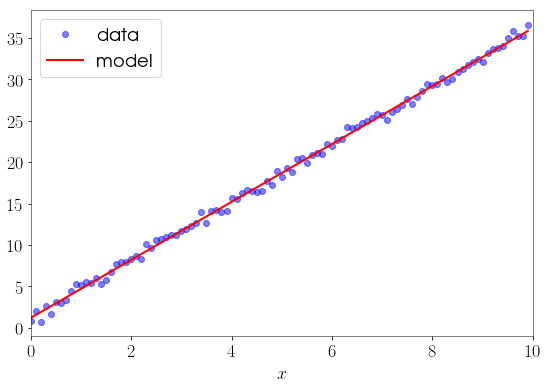

In [1]:
# show plots inline in the notebook
%matplotlib inline

from __future__ import division, print_function # python3 compatibilty

import numpy as np # import numpy
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl

# make the plots look a bit nicer with some defaults
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.sans-serif'] = 'Avant Garde, Helvetica, Computer Modern Sans serif'
rcparams['font.size'] = 18
mpl.rcParams.update(rcparams)

# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(0.0, 10.0, 10./M)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    
    return m*x + c

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
fig, ax = pl.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

## MCMC samplers

First up we'll deal with MCMC samplers that are purely written in Python, then a couple that are wrappers to other libraries.

### `emcee`

[`emcee`](http://dfm.io/emcee/current/) ([Foreman-Mackey _et al_, 2013](https://arxiv.org/abs/1202.3665)) is a Python MCMC implementation that uses an affine invariant ensemble sampler ([Goodman & Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml)). This basically means that it doesn't just evolve a single point in the model parameter space, but evolves and ensemble of points, and steps in the evolution are tuned based on the current state of the ensemble, so the steps scale naturally (the _affine invariant_ bit) as the ensemble closes in on the posterior. This code has been [well used](http://dfm.io/emcee/current/testimonials/) in the astrophysics community (and as an astrophysicisy myself I'm showing it as my first example!).

`emcee` is on [PyPI](https://pypi.org/) and is [installable](http://dfm.io/emcee/current/user/install/#using-pip) via `pip` with: `pip install emcee`. The example here is very similar to the [line model example](http://dfm.io/emcee/current/user/line/) given in the `emcee` documentation.

First up, we need to define the likelihood function, prior functions, and posterior probability function. These all need to be defined as the natural logarithms of the functions. All the functions take in a sample [tuple](https://docs.python.org/2/tutorial/datastructures.html#tuples-and-sequences), where a sample is vector $\vec{\theta}$ of parameter values, that can be unpacked to give the individual parameter values. Other arguments to the posterior function can be user defined.

#### Posterior

For our example the posterior will take the following form:

In [15]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.
    
    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """
    
    lp = logprior(theta) # get the prior
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

#### Likelihood

The likelihood will take the following form:

In [18]:
def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint likelihood.
    
    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    
    Note:
        We do not include the normalisation constants (as discussed above).
    """
    
    # unpack the model parameters from the tuple
    m, c = theta
    
    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)
    
    # return the log likelihood
    return -0.5*np.sum(((md - data)/sigma)**2)

#### Prior

The prior will take the following form:

In [16]:
def logprior(theta):
    """
    The natural logarithm of the prior probability.
    
    Args:
        theta (tuple): a sample containing individual parameter values
    
    Note:
        We can ignore the normalisations of the prior here.
    """
    
    lp = 0.
    
    # unpack the model parameters from the tuple
    m, c = theta
    
    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior
    
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if cmin < c < cmax else -np.inf
    
    # Gaussian prior on m
    mmu = 0.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2
    
    return lp

### MCMC set up

We need decide on a initial number of ensemble points and initialise the samples, i.e., set starting points for them. The initial samples can be drawn from the prior distributions (in the `emcee` documentation [example](http://dfm.io/emcee/current/user/line/) it starts the opposite way round, i.e., with initial samples tightly packed around the true value). We'll choose 100 ensembles (the number of so-called _walkers_) and initialise them with:

In [17]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = mmu + msigma*np.random.randn(Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = cmin + (cmax-cmin)*np.random.rand(Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Because our initial samples are drawn from the prior it can take time for them to converge on sampling from the posterior distributions that we want. To try and get around this we can run the sampler with a [burn-in](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect007.htm) period (although see, e.g., [here](http://users.stat.umn.edu/~geyer/mcmc/burn.html) or [here](https://www.johndcook.com/blog/2016/01/25/mcmc-burn-in/) for some discussions about whether burn-ins are actually necessary), and we will ignore samples during this burn-in. _[Note: Alternative options could be to use some optimisation routine to try and find the posterior modes and start samples at that point, or use all samples, work out an autocorrelation length and thin the samples accordingly so they are uncorrelated, which gets rid of correlations during the initial convergence of the samples.]_ We'll choose a burn-in of 500 samples, and then run the chain for another 500 samples, which will give an output with $(500+500)\times 100 = 100000$ samples.

In [19]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

The sampler first has to be initialise and told the required arguments, including any additional arguments for the posterior function:

In [24]:
import emcee # import the emcee package

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

Now the sampler can be run, and the burn-in removed, with:

In [21]:
from time import time # import time module to see how long it takes

# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 1.31844091415 seconds


Now plot the resulting posteriors using [corner.py](http://corner.readthedocs.io/en/latest/)!

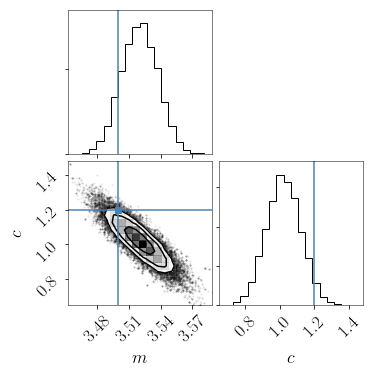

In [22]:
# plot the resulting posteriors
import corner
fig = corner.corner(samples, labels=["$m$", "$c$"], truths=[m, c])

### PyMC3

[PyMC3](http://docs.pymc.io/) ([Salvatier, Wiecki & Fonnesbeck, 2016](https://peerj.com/articles/cs-55/)) is a Python MCMC implementation that can use a variety of modern sampling method, including "No-U-turn sampling" (NUTS) ([Hoffman & Gellman, 2014](http://www.jmlr.org/papers/v15/hoffman14a.html)) and [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) ([Duane _et al_, 1987](http://www.sciencedirect.com/science/article/pii/037026938791197X)), both of which make use of the gradient of the posterior to efficiently sample the space. An example of getting started using PyMC3 can be found [here](http://docs.pymc.io/notebooks/getting_started), and upon which this example is based.

This code can also be installed using `pip` with: `pip install pymc3`.

The majority of distributions that can be used for priors and likehood functions are [predefined](http://docs.pymc.io/api/distributions.html) in PyMC3, so you do not have to worry about writing them yourself (although you can create your [own custom distribution](http://docs.pymc.io/notebooks/getting_started.html#Arbitrary-distributions)).

To set up the model we can't just use the `straight_line()` function defined above, but can do the following:

In [30]:
import pymc3 as pm # import PyMC3

# set the PyMC3 model
linear_model = pm.Model()

with linear_model:
    # set prior parameters
    cmin = -10. # lower range of uniform distribution on c
    cmax = 10.  # upper range of uniform distribution on c
    
    mmu = 0.     # mean of Gaussian distribution on m
    msigma = 10. # standard deviation of Gaussian distribution on m
    
    # set priors for unknown parameters
    cmodel = pm.Uniform('c', lower=cmin, upper=cmax) # uniform prior on y-intercept
    mmodel = pm.Normal('m', mu=mmu, sd=msigma)       # Gaussian prior on gradient
    
    sigmamodel = sigma # set a single standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Gaussian likelihood (sampling distribution) of observations, "data"
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=data)

Now we can perform the sampling. By default, for continuous variables like we have, the [sampling step method](http://docs.pymc.io/api/inference.html#step-methods) will use [NUTS](http://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts), but the method can be chosen manually. PyMC3 comes with a function for finding the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) point (MAP), which we will use to find a starting point for the sampling. We'll run with 1000 samples, and tune (like the burn-in above) with 1000 samples (discarding these tuning samples):

In [31]:
Nsamples = 1000 # final number of samples
Ntune = 1000    # number of tuning samples

# perform sampling
t0 = time()
with linear_model:
    start = pm.find_MAP() # find starting value using optimisation methods
    trace = pm.sample(Nsamples, start=start, tune=Ntune, discard_tuned_samples=True) # perform sampling
t1 = time()

timepymc3 = (t1-t0)
print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))

logp = -79.827, ||grad|| = 37.234: 100%|██████████| 16/16 [00:00<00:00, 5549.86it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:01<00:00, 1313.31it/s]

Time taken to run 'PyMC3' is 4.70852899551 seconds


PyMC3 has its own in-built [plotting functions](http://docs.pymc.io/api/plots.html) to, for example, show traces of the MCMC chains.

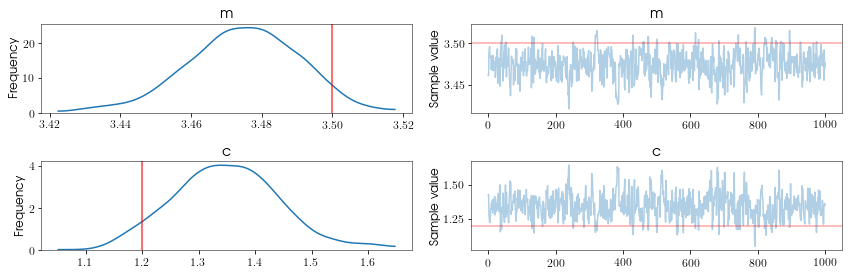

In [33]:
# plot trace output (overplot the true values)
rcparams['font.size'] = 12 # make font-size smaller
mpl.rcParams.update(rcparams)

_ = pm.traceplot(trace, lines={'m': m, 'c': c})

### MCMC wrapper samplers

There are other MCMC samplers that are not pure Python packages, but have a Python-based wrapper to a different library. With these you can't write pure Python model and probability functions, but instead have a create a code string that it then compiled and run using the underlying library functions. We will look at [PyStan](http://pystan.readthedocs.io) and [PyJAGS](https://pyjags.readthedocs.io).

### PyStan

[PyStan](http://pystan.readthedocs.io) is a Python interface to the popular [Stan](http://mc-stan.org/) library. As with PyMC3, it uses the modern NUTS and Hamiltonain MC sampling methods. It can be installed using `pip` with: `pip install pystan`.

To define the model and distributions you need to write a code string like this:

In [38]:
# model and distributions for straight line fitting
line_code = """
data {{
    int<lower=0> N;      // number of data points
    real y[N];           // observed data points
    real x[N];           // abscissa points
    real<lower=0> sigma; // standard deviation
}}
parameters {{
    // parameters for the fit
    real m;
    real c;
}}
transformed parameters {{
    real theta[N];
    for (j in 1:N)
    theta[j] = m * x[j] + c; // straight line model
}}
model {{
    m ~ normal({mmu}, {msigma});     // prior on m (gradient)
    c ~ uniform({clower}, {cupper}); // prior on c (y-intercept)
    y ~ normal(theta, sigma);        // likelihood of the data given the model
}}
"""

You can then define the inputs to the `data` section in a dictionary:

In [35]:
# set the data and the abscissa
linear_data = {'N': M,          # number of data points
               'y': data,       # observed data (converted from numpy array to a list)
               'x': x,          # abscissa points (converted from numpy array to a list)
               'sigma': sigma}  # standard deviation

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [39]:
import pystan # import PyStan

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0    # mean of Gaussian prior distribution for m
linedict['msigma'] = 10  # standard deviation of Gaussian prior distribution for m
linedict['clower'] = -10 # lower bound on uniform prior distribution for c
linedict['cupper'] = 10  # upper bound on uniform prior distribution for c

t0 = time()
sm = pystan.StanModel(model_code=line_code.format(**linedict)) # compile model
t1 = time()

timepystancomp = (t1-t0)

t0 = time()
fit = sm.sampling(data=linear_data, iter=Nsamples, chains=chains) # perform sampling
t1 = time()

timepystan = (t1-t0)

print("Time taken to comile 'PyStan' model is {} seconds".format(timepystancomp))
print("Time taken to run 'PyStan' is {} seconds".format(timepystan))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_15aa743a6e306b61e6880db7be28ca62 NOW.


Time taken to comile 'PyStan' model is 46.7560939789 seconds
Time taken to run 'PyStan' is 0.165381908417 seconds


PyStan does have a plotting function (you could run `fit.plot()`, but we'll extract the chains and use `corner.py`:

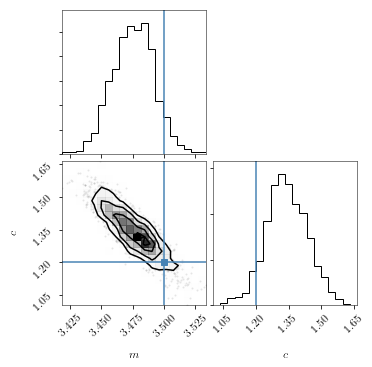

In [40]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mchain = la['m']
cchain = la['c']

# plot using corner.py
fig = corner.corner(np.array([mchain, cchain]).T, labels=[r'$m$', r'$c$'], truths=[m, c])

### PyJags

[PyJAGS](https://pyjags.readthedocs.io) is another wrapper to a non-Python library, in this case the [JAGS](http://mcmc-jags.sourceforge.net/) ([Plummer, 2003](http://www.ci.tuwien.ac.at/Conferences/DSC-2003/Proceedings/Plummer.pdf)). As with PyStan, you have to write a code script that is then compiled and run. To use PyJAGS you need to install JAGS, e.g. on a Debian-based system this can be done using:

`sudo apt-get install jags`

and then install PyJAGS using `pip` with:

`pip install pyjags`

> _Note_: _I had some problems with PyJAGS due to [numpy](http://www.numpy.org/) version issues, so to get it
> working I had to install it in a [Virtual Environment](https://virtualenv.pypa.io/en/stable/), with PyJAGS getting it's required numpy version._

A linear regression fitting example using PyJAGS is given [here](https://pyjags.readthedocs.io/en/latest/getting_started.html), on which this example is based.

We can define the model string using (note that in this model the Gaussian/Normal distribution takes the inverse variance as the second argument, rather than the standard deviation):

In [11]:
# create the JAGS code for the linear model
line_code_jags = '''
model {{
    for (i in 1:N) {{
        y[i] ~ dnorm(c + m * x[i], {invvar}) # Gaussian likelihood
    }}
    m ~ dnorm({mmu}, {minvvar})     # Gaussian prior on m
    c ~ dunif({clower}, {cupper})   # Uniform prior on c
}}
'''

You can then define the data inputs section in a dictionary:

In [3]:
datadict = {'x': x,    # abscissa points (converted from numpy array to a list)
            'N': M,    # number of data points
            'y': data} # the observed data

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [12]:
# add Virtual Environment containing PyJAGS to the PATH (see above note)
import sys
sys.path.insert(0, '/home/matthew/.local/share/virtualenvs/pyjags-me_UUHqp/lib/python2.7/site-packages')

import pyjags # import PyStan

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0           # mean of Gaussian prior distribution for m
linedict['minvvar'] = 1/10**2   # inverse variance of Gaussian prior distribution for m
linedict['clower'] = -10        # lower bound on uniform prior distribution for c
linedict['cupper'] = 10         # upper bound on uniform prior distribution for c
linedict['invvar'] = 1/sigma**2 # inverse variance of the data

# compile model
t0 = time()
model = pyjags.Model(line_code_jags.format(**linedict), data=datadict, chains=chains)
t1 = time()

timepyjagscomp = (t1-t0)

t0 = time()
samples = model.sample(Nsamples, vars=['m', 'c']) # perform sampling
t1 = time()

timepyjags = (t1-t0)

print("Time taken to comile 'PyJAGS' model is {} seconds".format(timepyjagscomp))
print("Time taken to run 'PyJAGS' is {} seconds".format(timepyjags))

# remove Virtual Environment from PATH
del sys.path[0]

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
Time taken to comile 'PyJAGS' model is 0.215706110001 seconds
Time taken to run 'PyJAGS' is 0.17196393013 seconds


Now we can plot the samples using `corner.py`:

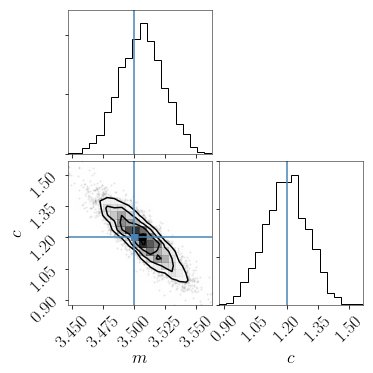

In [16]:
mchainjags = samples['m'].flatten()
cchainjags = samples['c'].flatten()

# plot using corner.py
fig = corner.corner(np.array([mchainjags, cchainjags]).T, labels=[r'$m$', r'$c$'], truths=[m, c])

That ends our exploration of MCMC codes. We now move on to Nested Sampling!

## Nested Sampling

[Nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) ([Skilling, 2006](https://projecteuclid.org/euclid.ba/1340370944)) is a method to numerically perform the integral required to evaluate the marginal likelihood of the data given a particular model. This is not a value that is produced by most standard MCMC methods, but is a value that is very useful if wanting to do [Bayesian model comparison](https://en.wikipedia.org/wiki/Bayes_factor). Above, we defined the marginal likelihood, or _evidence_, as

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

but, we can make this more explicit for a given hypothesis, or model, $H_j$, by stating:

$$
p(\mathbf{d}|H_j, I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta}, H_j, I) p(\vec{\theta}|H_j,I) {\rm d}{\theta_i},
$$

where previously the $H_j$ had been subsumed inside our implicit assumptions, $I$.

As well as producing a value for the marginal likelihood, a by-product of the nested sampling algorithm to to produce a set of samples that can be re-sampled from to produce samples drawn from the posterior distribution.

> _Note_: _MCMC methods can be used to estimate the marginal likelihood, e.g. `emcee` can be run with a [parallel tempering sampling method](http://dfm.io/emcee/current/user/pt/) and compute the evidence using thermodynamic integration (e.g., [Goggans & Chi, 2004](http://aip.scitation.org/doi/abs/10.1063/1.1751356)), or potentially using Slice sampling with PyMC3._

As with MCMC, there are various codes available to perform the nested sampling algorithm. We will again look at pure Python implementations and some that are wrappers to other libraries. 

### nestle

[nestle](http://kylebarbary.com/nestle/)

### CPNest

[cpnest](https://johnveitch.github.io/cpnest/) ([Veitch & del Pozzo, 2017](http://doi.org/10.5281/zenodo.835874))

Wrapper codes.

### PyMultiNest

[PyMultiNest](http://johannesbuchner.github.io/PyMultiNest/) ([Buchner _et al_, 2014](https://www.aanda.org/articles/aa/abs/2014/04/aa22971-13/aa22971-13.html))

### DNest4

[DNest4](https://github.com/eggplantbren/DNest4) ([Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757), [Brewer _et al_, 2011](https://arxiv.org/abs/0912.2380))

### PolyChord

[PolyChord](https://ccpforge.cse.rl.ac.uk/gf/project/polychord/) ([Handley _et al_, 2015](https://arxiv.org/abs/1502.01856))